In [1]:
# Score to measure reward
def judge(k, n, query, hidden):
    full_hits = 0
    color_hits = 0
    query_copy = query[:]
    hidden_copy = hidden[:]

    for q,h in zip(query,hidden):
        if q == h:
            full_hits += 1
            query_copy.remove(q)
            hidden_copy.remove(h)

    for q in query_copy:
        if q in hidden_copy:
            color_hits += 1
            hidden_copy.remove(q)

    return full_hits, color_hits

In [2]:
import random

# Game
class MastermindAI:
    def __init__(self, k, n, max_rounds, hidden=None):
        self.k = k
        self.n = n
        if hidden:
            self.hidden = hidden
        else:
            self.hidden = self.generate_hidden()
        self.round_n = 0
        self.max_rounds = max_rounds
        self.done = False
        self.game_over = False
        self.last_query = None
        self.last_judgement = (0,0)
        self.duplicated_query = False

    def generate_hidden(self):
        hidden = [random.randint(1,self.k) for color in range(self.n)]
        return hidden

    def play_step(self, query):
        self.round_n += 1
        reward = 0
        X0, Y0 = self.last_judgement
        X1, Y1 = judge(self.k, self.n, query, self.hidden)  # full hits and color hits
        reward = self.n * (X1 - X0) * 10 + (Y1 - Y0) * 10  # Reward for the difference hits between rounds (1 full hit reward = n color hits)
        if X1 == 4:
            self.done = True
            # self.score += 1
        if self.round_n >= self.max_rounds:
            # reward = -10 * self.n  # Penalty for loss
            self.game_over = True
        # Penalty for guessing out of E0???
        # Penalty for duplicating a query
        if query == self.last_query:
            reward = -self.n
            self.duplicated_query = True
        else:
            self.duplicated_query = False
        self.last_query = query
        self.last_judgement = (X1, Y1)
        return reward, self.round_n, self.done, self.game_over

    def reset(self, hidden=None):
        # Initialize game state
        if hidden:
            self.hidden = hidden
        else:
            self.hidden = self.generate_hidden()
        self.round_n = 0
        self.done = False
        self.game_over = False
        self.last_query = None

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import os


# Model
class Linear_QNet(torch.nn.Module):
    def __init__(self, k, n, hidden_size):
        super(Linear_QNet, self).__init__()
        self.k = k
        self.n = n
        self.flatten = torch.nn.Flatten(1,-1)
        self.linear1 = torch.nn.Linear(self.k*self.n, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, self.k*self.n)

    def forward(self, x, batch_size=1):
        # Frequency matrix
        scaler = x.detach().clone()

        # Flatten k x n color position count matrix
        x = self.flatten(x)

        # Input layer
        x = self.linear1(x)
        x = F.relu(x)

        # Hidden layer
        x = self.linear2(x)

        # Reshape to k x n position probability matrix
        x = torch.reshape(x, (batch_size, self.k, self.n))

        # Change all values to positive
        x = torch.abs(x)

        # Scale output by frequency matrix -> reduce positons not present in E0, enhance more frequent positions
        x = x * scaler  # ???

        return x

    def save(self, filename='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        filepath = os.path.join(model_folder_path, filename)
        torch.save(self.state_dict(), filepath)


class QTrainer:
    def __init__(self, model: Linear_QNet, lr, gamma):
        self.model = model
        self.lr = lr
        self.gamma = gamma
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = torch.nn.MSELoss()

    def train_step(self, state, query, reward, next_state, done, game_over):
        state = torch.tensor(state, dtype=torch.float)
        query = torch.tensor(query, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)

        if len(state.shape) == 2:  # Two dimentional vector for short memory training
            # shape(1,x) -> iterate through 1 sample the same as through batch
            state = torch.unsqueeze(state, 0)
            query = torch.unsqueeze(query, 0)
            reward = torch.unsqueeze(reward, 0)
            next_state = torch.unsqueeze(next_state, 0)
            done = (done, )
            game_over = (game_over, )

        # 1: predicted Q-values with current state
        prediction = self.model(state, batch_size=state.shape[0])
        # prediction = torch.reshape(prediction, (self.model.k, self.model.n))  # Reshape to k x n position probability matrix
        # if len(prediction.shape) == 2:
        #     prediction = torch.unsqueeze(prediction, 0)  # ???

        target = prediction.clone()
        for i in range(len(done)):
            Q_new = np.full((target.shape[2], ), float(reward[i])) # Full hit reward scaled so 1 full hit == n color hits
            if not game_over[i] and not done[i]:  # Separate reward for the win or not?
                Q_new = reward[i] + self.gamma * torch.max(self.model(torch.unsqueeze(next_state[i], 0)), 1).values.detach().numpy()[0]

            for j, arg_idx in enumerate([int(color-1) for color in query[i]]):
                target[i][arg_idx][j] = Q_new[j]  # Set max value in each position to Q_new

        # 2: Q_new = Reward + gamma * max(next_predicted Q-value) -> only do this if not done or game_over
        self.optimizer.zero_grad()
        loss = self.criterion(target, prediction)
        loss.backward()

        self.optimizer.step()


print(Linear_QNet(8,4,256))

Linear_QNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=32, bias=True)
)


In [4]:
import matplotlib.pyplot as plt
from IPython import display

# Helper
plt.ion()

def plot(scores, mean_scores):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))

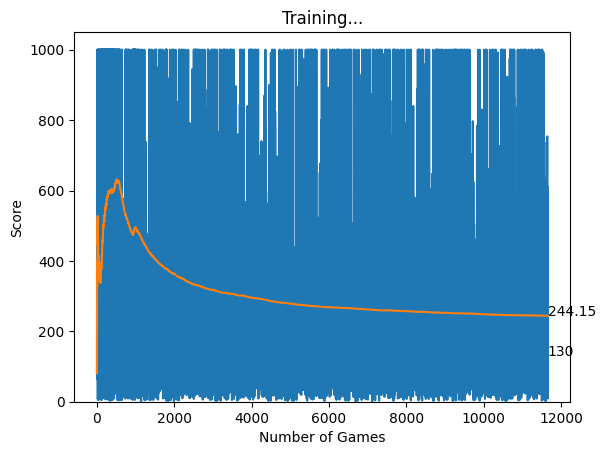

Game: 11662 | Score: 384 | Record: 1


In [ ]:
from copy import deepcopy
import numpy as np
import torch
from itertools import product
from collections import deque

# Agent
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.01


class Agent:

    def __init__(self, k, n):
        self.k = k
        self.n = n
        self.n_games = 0
        self.epsilon = 0  # randomness
        self.gamma = 0.9  # discount rate
        self.memory = deque(maxlen=MAX_MEMORY)  # pop left if MAX_MEMORY is reached
        self.possible_sequences = [list(i) for i in product([j for j in range(1,self.k+1)], repeat=self.n)]  # All possible sequences
        self.E0 = self.possible_sequences[:] # All eligable sequences
        self.E0_encoded = np.full((self.k,self.n), pow(self.k, self.n-1))  # Color position count matrix for all possible sequences (k colors x n sequence length)
        self.model = Linear_QNet(self.k, self.n, 256)  # Hidden layers tweakable
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)


    def get_state(self, game: MastermindAI) -> list[int]:
        # Color position count matrix for eligable sequences
        E1 = []
        E1_encoded = np.full_like(self.E0_encoded, 0)

        if game.last_query:
            last_query = game.last_query
            X0, Y0 = game.last_judgement
            if not game.duplicated_query and last_query in self.E0:  # ???
                for sequence in self.E0:
                    X1, Y1 = judge(self.k, self.n, sequence, last_query)
                    if X0 == X1 and Y0 == Y1:
                        E1.append(sequence)
                        for i, color in enumerate(sequence):
                            E1_encoded[color-1,i] += 1

                # Update E0
                self.E0 = E1
                self.E0_encoded = E1_encoded

        return self.E0_encoded


    def remember(self, state, query, reward, next_state, done, game_over):
        self.memory.append((state, query, reward, next_state, done, game_over))


    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_batch = random.sample(self.memory, BATCH_SIZE)  # list of tuples
        else:
            mini_batch = self.memory

        states, queries, rewards, next_states, dones, game_overs = zip(*mini_batch)
        self.trainer.train_step(states, queries, rewards, next_states, dones, game_overs)


    def train_short_memory(self, state, query, reward, next_state, done, game_over):
        self.trainer.train_step(state, query, reward, next_state, done, game_over)


    def get_action(self, state):
        # random moves: tradeoff exploration vs exploitation
        # While the game progresses actions tend to be less random
        self.epsilon = 100 - self.n_games  # TWEAK
        if random.randint(0,200) < self.epsilon:
            final_query = random.sample(self.possible_sequences, 1)[0]

        else:
            state = torch.tensor(state, dtype=torch.float)
            state = torch.unsqueeze(state, 0)
            prediction = self.model(state)[0]
            # prediction = torch.reshape(prediction, (self.model.k, self.model.n))  # Reshape to k x n position probability matrix
            query_encoded = torch.argmax(prediction, dim=0).tolist()
            final_query = [color+1 for color in query_encoded]

        return final_query


    def reset(self):
        self.E0 = self.possible_sequences[:] # All eligable sequences
        self.E0_encoded = np.full((self.k,self.n), pow(self.k, self.n-1))  # Color position count matrix for all possible sequences (k colors x n sequence length)



def train(k, n, max_rounds, hidden=None):
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 100
    agent = Agent(k, n)
    game = MastermindAI(k, n, max_rounds, hidden)
    while True:
        # Get old state
        # state_old = agent.get_state(game)
        state_old = agent.E0_encoded

        # Get guess
        final_query = agent.get_action(state_old)

        # Perform guess and get new state
        reward, score, done, game_over = game.play_step(final_query)
        state_new = agent.get_state(game)

        # # Penalty for guessing out of E0
        # if final_query not in agent.E0:
        #     reward = -10 * game.n

        # Train short memory
        agent.train_short_memory(state_old, final_query, reward, state_new, done, game_over)

        # Remember
        agent.remember(state_old, final_query, reward, state_new, done, game_over)

        if done or game_over:
            # Train long memory, plot result
            game.reset()
            agent.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score < record:
                record = score
                # agent.model.save()

            print(f'Game: {agent.n_games} | Score: {score} | Record: {record}')

            plot_scores.append(score)
            total_score += score
            mean_score = round(total_score / agent.n_games, 2)
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)



if __name__ == '__main__':
    train(8, 4, 1000)

In [ ]:
state = torch.tensor(np.array([[4,1,5],[5,1,4],[1,5,4],[5,4,1]]), dtype=torch.float)
print(state)
query_encode = torch.max(state, dim=0)
print(query_encode)
print([color+1 for color in query_encode])

tensor([[4., 1., 5.],
        [5., 1., 4.],
        [1., 5., 4.],
        [5., 4., 1.]])
torch.return_types.max(
values=tensor([5., 5., 5.]),
indices=tensor([1, 2, 0]))
[tensor([6., 6., 6.]), tensor([2, 3, 1])]


In [ ]:
criterion = torch.nn.MSELoss()
state2 = torch.tensor(np.array([[4,1,9],[9,1,4],[1,9,4],[5,4,1]]), dtype=torch.float)
criterion(state, state2)

tensor(4.)

In [ ]:
x = torch.nn.Flatten(1, -1)
state_flat = x(state)
print(state_flat)
state_reshape = torch.reshape(state_flat, (4,3))
print(state_reshape)
state_unsqueeze = torch.unsqueeze(state_reshape, 0)
state_unsqueeze2 = torch.cat((state_unsqueeze, state_unsqueeze), 0)
print(state_unsqueeze2)
print(x(state_unsqueeze2))

print(torch.max(state_unsqueeze, 1))

model = Linear_QNet(4,3,256)
pred = model(state_unsqueeze2, 2)
print(pred)

tensor([[4., 1., 5.],
        [5., 1., 4.],
        [1., 5., 4.],
        [5., 4., 1.]])
tensor([[4., 1., 5.],
        [5., 1., 4.],
        [1., 5., 4.],
        [5., 4., 1.]])
tensor([[[4., 1., 5.],
         [5., 1., 4.],
         [1., 5., 4.],
         [5., 4., 1.]],

        [[4., 1., 5.],
         [5., 1., 4.],
         [1., 5., 4.],
         [5., 4., 1.]]])
tensor([[4., 1., 5., 5., 1., 4., 1., 5., 4., 5., 4., 1.],
        [4., 1., 5., 5., 1., 4., 1., 5., 4., 5., 4., 1.]])
torch.return_types.max(
values=tensor([[5., 5., 5.]]),
indices=tensor([[1, 2, 0]]))
tensor([[[ 0.0423, -2.2662, -0.2586],
         [ 0.2928, -0.1103,  2.0704],
         [-0.8288, -0.3948,  0.4991],
         [ 0.7937,  0.4156, -0.7626]],

        [[ 0.0423, -2.2662, -0.2586],
         [ 0.2928, -0.1103,  2.0704],
         [-0.8288, -0.3948,  0.4991],
         [ 0.7937,  0.4156, -0.7626]]], grad_fn=<ViewBackward0>)


In [ ]:
game = MastermindAI(4, 3, 100)
print(game.hidden)
agent = Agent(4, 3)
print(agent.get_state(game))
print(agent.E0)
game.last_query = [1,1]
game.last_reward = judge(4,3,game.hidden,[1,1,4])
print(agent.get_state(game))
print(agent.E0)

[3, 2, 2]
[[16 16 16]
 [16 16 16]
 [16 16 16]
 [16 16 16]]
[[1, 1, 1], [1, 1, 2], [1, 1, 3], [1, 1, 4], [1, 2, 1], [1, 2, 2], [1, 2, 3], [1, 2, 4], [1, 3, 1], [1, 3, 2], [1, 3, 3], [1, 3, 4], [1, 4, 1], [1, 4, 2], [1, 4, 3], [1, 4, 4], [2, 1, 1], [2, 1, 2], [2, 1, 3], [2, 1, 4], [2, 2, 1], [2, 2, 2], [2, 2, 3], [2, 2, 4], [2, 3, 1], [2, 3, 2], [2, 3, 3], [2, 3, 4], [2, 4, 1], [2, 4, 2], [2, 4, 3], [2, 4, 4], [3, 1, 1], [3, 1, 2], [3, 1, 3], [3, 1, 4], [3, 2, 1], [3, 2, 2], [3, 2, 3], [3, 2, 4], [3, 3, 1], [3, 3, 2], [3, 3, 3], [3, 3, 4], [3, 4, 1], [3, 4, 2], [3, 4, 3], [3, 4, 4], [4, 1, 1], [4, 1, 2], [4, 1, 3], [4, 1, 4], [4, 2, 1], [4, 2, 2], [4, 2, 3], [4, 2, 4], [4, 3, 1], [4, 3, 2], [4, 3, 3], [4, 3, 4], [4, 4, 1], [4, 4, 2], [4, 4, 3], [4, 4, 4]]
[[0 0 0]
 [9 9 9]
 [9 9 9]
 [9 9 9]]
[[2, 2, 2], [2, 2, 3], [2, 2, 4], [2, 3, 2], [2, 3, 3], [2, 3, 4], [2, 4, 2], [2, 4, 3], [2, 4, 4], [3, 2, 2], [3, 2, 3], [3, 2, 4], [3, 3, 2], [3, 3, 3], [3, 3, 4], [3, 4, 2], [3, 4, 3], [3, 4, 4], 

In [ ]:
# Game
k = 8
n = 4
hidden = [3,1,7,2]
X1, Y1 = 0, 0

while X1 < 4:
    guess = input("Your query: ")
    query = [int(color) for color in guess.split()]
    X1, Y1 = judge(k,n,query,hidden)
    print(X1, Y1)

print('Congrats')

Your query: 3 1 7 2
4 0
Congrats
